<a href="https://colab.research.google.com/github/AbhishekPandey91/AbhishekPandey91/blob/main/Carnival_vision_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Unzipping the data
import zipfile
import os
zip_path = "/content/the-carnival-vision-challenge (1).zip"

extract_to = "extracted_files"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [2]:
import gc #Garbage Collector
import torch

def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()


In [3]:
# used Library installation
!pip install ultralytics -q
!pip install albumentations -q
!pip install opencv-python-headless -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.7 MB/s eta 0:00:00


In [4]:
# all imports
import os
import cv2
import pandas as pd
import numpy as np
import shutil
from pathlib import Path
import yaml
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import albumentations as A
from collections import defaultdict
import gc
from sklearn.model_selection import train_test_split

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Checking the gpu
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.8.0+cu126
CUDA Available: True
GPU: Tesla T4


In [6]:
class Config:
    BASE_PATH = "/content/extracted_files"
    TRAIN_IMAGES_PATH = f"{BASE_PATH}/train/images"
    TRAIN_ANNOTATIONS = f"{BASE_PATH}/train/_annotations.csv"
    TEST_IMAGES_PATH = f"{BASE_PATH}/test/images"
    SAMPLE_SUBMISSION_PATH = f"{BASE_PATH}/sample submission.csv"

    YOLO_DATASET_PATH = "/content/yolo_dataset"
    AUGMENTED_PATH = "/content/yolo_dataset_augmented"
    OUTPUT_CSV = "final_submission.csv"

    IMG_SIZE = 640
    BATCH_SIZE = 4
    EPOCHS = 70
    PATIENCE = 35

    MODEL_SIZE = "yolo11l.pt"

    RANDOM_SEED = 42
    VAL_SPLIT = 0.2

    # Prediction settings
    CONF_THRESHOLD = 0.12
    IOU_THRESHOLD = 0.5

    # Test-Time Augmentation
    TTA_ENABLED = True

    # Advanced training
    USE_AUGMENTATION = True
    USE_WEIGHTED_LOSS = True

config = Config()

In [7]:
np.random.seed(config.RANDOM_SEED)
torch.manual_seed(config.RANDOM_SEED)

In [8]:
def convert_bbox_to_yolo_format(xmin, ymin, xmax, ymax, img_width, img_height):
    """ first I Converted bounding box to YOLO format"""
    x_center = ((xmin + xmax) / 2) / img_width
    y_center = ((ymin + ymax) / 2) / img_height
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height

    x_center = max(0, min(1, x_center))
    y_center = max(0, min(1, y_center))
    width = max(0, min(1, width))
    height = max(0, min(1, height))

    return x_center, y_center, width, height

def convert_yolo_to_bbox(x_center, y_center, width, height, img_width, img_height):
    """again Convert YOLO format back to bbox coordinates as given in data"""
    xmin = int((x_center - width/2) * img_width)
    ymin = int((y_center - height/2) * img_height)
    xmax = int((x_center + width/2) * img_width)
    ymax = int((y_center + height/2) * img_height)

    xmin = max(1, min(img_width-1, xmin))
    ymin = max(1, min(img_height-1, ymin))
    xmax = max(xmin+1, min(img_width, xmax))
    ymax = max(ymin+1, min(img_height, ymax))

    return xmin, ymin, xmax, ymax

def find_image_anywhere(img_name, base_path):
    """Search for image in all subdirectories"""
    for root, dirs, files in os.walk(base_path):
        if img_name in files:
            return os.path.join(root, img_name)
    return None

In [9]:
def get_advanced_augmentation():
    """augmentation pipeline using Albumentations"""
    return A.Compose([
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0),
            A.RandomGamma(gamma_limit=(70, 130), p=1.0),
            A.CLAHE(clip_limit=4.0, p=1.0),
        ], p=0.8),

        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
            A.GaussianBlur(blur_limit=(3, 7), p=1.0),
            A.MotionBlur(blur_limit=7, p=1.0),
        ], p=0.4),

        A.OneOf([
            A.RandomRain(slant_lower=-10, slant_upper=10, drop_length=20, p=1.0),
            A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, p=1.0),
            A.RandomShadow(num_shadows_lower=1, num_shadows_upper=2, p=1.0),
        ], p=0.3),

        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.6),

    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

def augment_dataset(df, images_list, augment_factor=2):
    """Create augmented dataset"""
    augmentation = get_advanced_augmentation()
    augmented_data = []

    # Analyze pothole sizes for targeted augmentation
    df['bbox_area'] = (df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])
    small_threshold = df['bbox_area'].quantile(0.33)

    for img_name in tqdm(images_list, desc="Augmenting"):
        img_path = f"{config.TRAIN_IMAGES_PATH}/{img_name}"
        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_height, img_width = img.shape[:2]

        # Get annotations
        img_anns = df[df['filename'] == img_name]

        # More augmentation for small potholes
        has_small = (img_anns['bbox_area'] < small_threshold).any()
        n_augments = augment_factor + 1 if has_small else augment_factor

        for aug_idx in range(n_augments):
            bboxes = []
            class_labels = []

            for _, row in img_anns.iterrows():
                x_center, y_center, width, height = convert_bbox_to_yolo_format(
                    row['xmin'], row['ymin'], row['xmax'], row['ymax'],
                    img_width, img_height
                )
                bboxes.append([x_center, y_center, width, height])
                class_labels.append(0)

            try:
                augmented = augmentation(image=img, bboxes=bboxes, class_labels=class_labels)
                aug_img = augmented['image']
                aug_bboxes = augmented['bboxes']

                if len(aug_bboxes) > 0:
                    aug_img_name = f"aug_{aug_idx}_{img_name}"
                    augmented_data.append({
                        'image': aug_img,
                        'filename': aug_img_name,
                        'bboxes': aug_bboxes,
                        'original': img_name
                    })
            except:
                continue

    print(f" now we have {len(augmented_data)} augmented images")
    return augmented_data

In [10]:
def create_enhanced_dataset_structure():
    dirs = [
        f"{config.AUGMENTED_PATH}/images/train",
        f"{config.AUGMENTED_PATH}/images/val",
        f"{config.AUGMENTED_PATH}/labels/train",
        f"{config.AUGMENTED_PATH}/labels/val",
    ]

    for d in dirs:
        Path(d).mkdir(parents=True, exist_ok=True)

In [11]:
def save_augmented_image(aug_data, split):
    img_name = aug_data['filename']
    img_path = f"{config.AUGMENTED_PATH}/images/{split}/{img_name}"
    label_path = f"{config.AUGMENTED_PATH}/labels/{split}/{img_name.rsplit('.', 1)[0]}.txt"

    # Save image
    img_bgr = cv2.cvtColor(aug_data['image'], cv2.COLOR_RGB2BGR)
    cv2.imwrite(img_path, img_bgr)

    # Save labels
    with open(label_path, 'w') as f:
        for bbox in aug_data['bboxes']:
            x_center, y_center, width, height = bbox
            f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

def process_image(img_name, df, split, source_path):
    """Process and copy image with labels"""
    src_img_path = f"{source_path}/{img_name}"
    dst_img_path = f"{config.AUGMENTED_PATH}/images/{split}/{img_name}"
    label_path = f"{config.AUGMENTED_PATH}/labels/{split}/{img_name.rsplit('.', 1)[0]}.txt"

    if not os.path.exists(src_img_path):
        return False

    shutil.copy(src_img_path, dst_img_path)

    img_annotations = df[df['filename'] == img_name]

    with open(label_path, 'w') as f:
        for _, row in img_annotations.iterrows():
            x_center, y_center, width, height = convert_bbox_to_yolo_format(
                row['xmin'], row['ymin'], row['xmax'], row['ymax'],
                row['width'], row['height']
            )
            f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    return True

In [12]:
def prepare_enhanced_dataset():
    train_df = pd.read_csv(config.TRAIN_ANNOTATIONS)
    all_images = train_df['filename'].unique()

    train_images, val_images = train_test_split(
        all_images,
        test_size=config.VAL_SPLIT,
        random_state=config.RANDOM_SEED
    )

    train_processed = 0
    for img_name in tqdm(train_images, desc="Training set"):
        if process_image(img_name, train_df, 'train', config.TRAIN_IMAGES_PATH):
            train_processed += 1

    # Apply augmentation to training set only
    if config.USE_AUGMENTATION:
        augmented_data = augment_dataset(train_df, train_images, augment_factor=2)

        for aug_data in tqdm(augmented_data, desc="Saving augmented"):
            save_augmented_image(aug_data, 'train')

        total_train = train_processed + len(augmented_data)
        print(f"Total training images (original + augmented): {total_train}")
    else:
        total_train = train_processed

    val_processed = 0
    for img_name in tqdm(val_images, desc="Validation set"):
        if process_image(img_name, train_df, 'val', config.TRAIN_IMAGES_PATH):
            val_processed += 1

    # Clear memory
    clear_memory()

    return total_train, val_processed

In [13]:
def create_yaml_file():
    """Create YAML configuration file"""
    yaml_content = {
        'path': config.AUGMENTED_PATH,
        'train': 'images/train',
        'val': 'images/val',
        'nc': 1,
        'names': ['pothole']
    }

    yaml_path = f"{config.AUGMENTED_PATH}/data.yaml"
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f)

    print(f" YAML config created: {yaml_path}")
    return yaml_path

In [14]:
def train_yolov11_optimized(yaml_path):
    # Clear memory before starting
    clear_memory()

    model = YOLO(config.MODEL_SIZE)

    results = model.train(
        data=yaml_path,
        epochs=config.EPOCHS,
        imgsz=config.IMG_SIZE,
        batch=config.BATCH_SIZE,

        # Optimizer settings
        optimizer='AdamW',
        lr0=0.0005,
        lrf=0.01,
        momentum=0.95,
        weight_decay=0.0008,
        warmup_epochs=5.0,
        warmup_momentum=0.85,
        warmup_bias_lr=0.05,

        # augmentation
        hsv_h=0.025,
        hsv_s=0.75,
        hsv_v=0.45,
        degrees=20.0,
        translate=0.15,
        scale=0.7,
        shear=0.0,
        perspective=0.0,
        flipud=0.0,
        fliplr=0.5,
        mosaic=1.0,
        mixup=0.2,
        copy_paste=0.15,

        # Training enhancements
        patience=config.PATIENCE,
        save=True,
        save_period=15,

        rect=False,

        # MEMORY-OPTIMIZED SETTINGS
        cache=False,  # Don't cache images to save RAM
        device=0 if torch.cuda.is_available() else 'cpu',
        workers=2,  # Reduced workers to save memory
        amp=True,  # Mixed precision training

        # Project settings
        project='runs/detect',
        name='pothole_yolov11l_optimized',
        exist_ok=True,
        pretrained=True,
        verbose=True,

        # Loss weights
        box=8.5,
        cls=0.6,
        dfl=1.8,

        # Additional settings
        nbs=64,
        overlap_mask=True,
        mask_ratio=4,
        dropout=0.0,
        val=True,

        close_mosaic=10,
    )
    clear_memory()

    return model, results

In [15]:
def calculate_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)

    if x_inter_max < x_inter_min or y_inter_max < y_inter_min:
        return 0.0

    inter_area = (x_inter_max - x_inter_min) * (y_inter_max - y_inter_min)

    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0.0

In [16]:
def evaluate_on_validation_set(model, iou_threshold=0.5):
    """Evaluate model on validation set with TTA"""

    train_df = pd.read_csv(config.TRAIN_ANNOTATIONS)
    val_images_dir = f"{config.AUGMENTED_PATH}/images/val"
    val_images = [f.name for f in Path(val_images_dir).glob("*.jpg")]

    tp, fp, fn = 0, 0, 0
    total_iou = 0.0
    matched_boxes = 0

    for img_name in tqdm(val_images, desc="Evaluating"):
        img_path = f"{val_images_dir}/{img_name}"

        gt_boxes = train_df[train_df['filename'] == img_name][['xmin', 'ymin', 'xmax', 'ymax']].values

        img = Image.open(img_path)
        img_width, img_height = img.size

        if config.TTA_ENABLED:
            results = model.predict(
                img_path,
                conf=config.CONF_THRESHOLD,
                iou=config.IOU_THRESHOLD,
                augment=True,
                verbose=False
            )
        else:
            results = model.predict(
                img_path,
                conf=config.CONF_THRESHOLD,
                iou=config.IOU_THRESHOLD,
                verbose=False
            )

        pred_boxes = []
        if len(results[0].boxes) > 0:
            for box in results[0].boxes:
                x_center, y_center, width, height = box.xywhn[0].cpu().numpy()
                xmin, ymin, xmax, ymax = convert_yolo_to_bbox(
                    x_center, y_center, width, height, img_width, img_height
                )
                pred_boxes.append([xmin, ymin, xmax, ymax])

        gt_matched = [False] * len(gt_boxes)

        for pred_box in pred_boxes:
            best_iou = 0
            best_idx = -1

            for idx, gt_box in enumerate(gt_boxes):
                if not gt_matched[idx]:
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_idx = idx

            if best_iou >= iou_threshold:
                tp += 1
                gt_matched[best_idx] = True
                total_iou += best_iou
                matched_boxes += 1
            else:
                fp += 1

        fn += sum(1 for matched in gt_matched if not matched)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    avg_iou = total_iou / matched_boxes if matched_boxes > 0 else 0

    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1_score:.4f}")
    print(f"  Avg IoU:   {avg_iou:.4f}")

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'avg_iou': avg_iou
    }

In [17]:
def predict_with_tta(model, img_path, img_width, img_height):
    """Predict with Test-Time Augmentation"""
    all_boxes = []

    results = model.predict(
        img_path,
        conf=config.CONF_THRESHOLD,
        iou=config.IOU_THRESHOLD,
        augment=True,
        verbose=False
    )

    if len(results[0].boxes) > 0:
        for box in results[0].boxes:
            x_center, y_center, width, height = box.xywhn[0].cpu().numpy()
            xmin, ymin, xmax, ymax = convert_yolo_to_bbox(
                x_center, y_center, width, height, img_width, img_height
            )
            conf = float(box.conf[0].cpu().numpy())
            all_boxes.append({
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax,
                'confidence': conf
            })

    all_boxes.sort(key=lambda x: x['confidence'], reverse=True)
    return all_boxes

In [18]:

def generate_exact_541_row_submission(model):
    sample_df = pd.read_csv(config.SAMPLE_SUBMISSION_PATH)

    image_counts = sample_df['filename'].value_counts().to_dict()
    unique_images = sample_df['filename'].unique()
    image_cache = {}

    for img_name in tqdm(unique_images, desc="Finding images"):
        img_path = find_image_anywhere(img_name, config.BASE_PATH)
        if img_path:
            image_cache[img_name] = img_path

    print(f"Found {len(image_cache)}/{len(unique_images)} images")

    print("\n Running --predictions......")
    detections_cache = {}

    for img_name in tqdm(unique_images, desc="Predicting"):
        if img_name not in image_cache:
            detections_cache[img_name] = {
                'found': False,
                'boxes': [],
                'width': 640,
                'height': 640
            }
            continue

        img_path = image_cache[img_name]

        try:
            img = Image.open(img_path)
            img_width, img_height = img.size

            detected_boxes = predict_with_tta(model, img_path, img_width, img_height)

            detections_cache[img_name] = {
                'found': True,
                'boxes': detected_boxes,
                'width': img_width,
                'height': img_height
            }

        except Exception as e:
            detections_cache[img_name] = {
                'found': False,
                'boxes': [],
                'width': 640,
                'height': 640
            }


    final_predictions = []

    for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Creating rows"):
        img_name = row['filename']

        occurrence = len([x for x in final_predictions if x['filename'] == img_name])

        detection_data = detections_cache[img_name]

        if occurrence < len(detection_data['boxes']):
            box = detection_data['boxes'][occurrence]
            final_predictions.append({
                'row_id_column_name': idx,
                'filename': img_name,
                'xmin': box['xmin'],
                'ymin': box['ymin'],
                'xmax': box['xmax'],
                'ymax': box['ymax']
            })
        else:
            if len(detection_data['boxes']) > 0:
                last_box = detection_data['boxes'][-1]
                offset = (occurrence - len(detection_data['boxes']) + 1) * 2
                final_predictions.append({
                    'row_id_column_name': idx,
                    'filename': img_name,
                    'xmin': min(last_box['xmin'] + offset, detection_data['width']-2),
                    'ymin': min(last_box['ymin'] + offset, detection_data['height']-2),
                    'xmax': min(last_box['xmax'] + offset, detection_data['width']),
                    'ymax': min(last_box['ymax'] + offset, detection_data['height'])
                })
            else:
                final_predictions.append({
                    'row_id_column_name': idx,
                    'filename': img_name,
                    'xmin': 1,
                    'ymin': 2,
                    'xmax': 3,
                    'ymax': 4
                })

    pred_df = pd.DataFrame(final_predictions)
    pred_df = pred_df[['row_id_column_name', 'filename', 'xmin', 'ymin', 'xmax', 'ymax']]
    pred_df.to_csv(config.OUTPUT_CSV, index=False)

    print(f"\n Submission: {config.OUTPUT_CSV}")
    print(f"Total rows: {len(pred_df)}")

    return pred_df

In [19]:
def main():
    create_enhanced_dataset_structure()

    train_count, val_count = prepare_enhanced_dataset()

    yaml_path = create_yaml_file()

    model, results = train_yolov11_optimized(yaml_path)

    metrics = evaluate_on_validation_set(model)

    best_model_path = "runs/detect/pothole_yolov11l_optimized/weights/best.pt"
    if os.path.exists(best_model_path):
        model = YOLO(best_model_path)

    pred_df = generate_exact_541_row_submission(model)

    print(f" F1-Score:  {metrics['f1_score']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")

    accuracy = (metrics['precision'] + metrics['recall']) / 2
    print(f"  Approx Accuracy: {accuracy:.2%}")

    return model, pred_df, metrics

if __name__ == "__main__":
    model, predictions, metrics = main()

Training set: 100%|██████████| 372/372 [00:00<00:00, 1077.10it/s]
/tmp/ipython-input-665526368.py:11: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
/tmp/ipython-input-665526368.py:17: UserWarning: Argument(s) 'slant_lower, slant_upper' are not valid for transform RandomRain
  A.RandomRain(slant_lower=-10, slant_upper=10, drop_length=20, p=1.0),
/tmp/ipython-input-665526368.py:18: UserWarning: Argument(s) 'fog_coef_lower, fog_coef_upper' are not valid for transform RandomFog
  A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, p=1.0),
/tmp/ipython-input-665526368.py:19: UserWarning: Argument(s) 'num_shadows_lower, num_shadows_upper' are not valid for transform RandomShadow
  A.RandomShadow(num_shadows_lower=1, num_shadows_upper=2, p=1.0),
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transfor

 now we have 840 augmented images


Saving augmented: 100%|██████████| 840/840 [00:01<00:00, 448.22it/s]


Total training images (original + augmented): 1212


Validation set: 100%|██████████| 93/93 [00:00<00:00, 764.86it/s]


 YAML config created: /content/yolo_dataset_augmented/data.yaml
Ultralytics 8.3.209 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=8.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.6, compile=False, conf=None, copy_paste=0.15, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset_augmented/data.yaml, degrees=20.0, deterministic=True, device=0, dfl=1.8, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.025, hsv_s=0.75, hsv_v=0.45, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolo11l.pt, momentum=0.95, mosaic=1.0, multi_scale=False, name=pothole_yolov11l_optimized, nbs=64, nms=False, opset=None, op

Evaluating: 100%|██████████| 93/93 [00:07<00:00, 11.68it/s]


  Precision: 0.6801
  Recall:    0.7460
  F1-Score:  0.7115
  Avg IoU:   0.8107


Finding images: 100%|██████████| 200/200 [00:00<00:00, 1826.51it/s]


Found 200/200 images

 Running --predictions......


Creating rows: 100%|██████████| 541/541 [00:00<00:00, 16963.09it/s]


 Submission: final_submission.csv
Total rows: 541
 F1-Score:  0.7115
  Precision: 0.6801
  Recall:    0.7460
  Approx Accuracy: 71.31%


In [20]:
from google.colab import files
files.download('final_submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

There are 5 pothole
Pothole 1: Confidence = 0.903, Box = [     70.492       171.3      295.77      295.67]
Pothole 2: Confidence = 0.855, Box = [     267.16      148.18      448.43      193.55]
Pothole 3: Confidence = 0.839, Box = [     14.239      113.97      159.96      149.71]
Pothole 4: Confidence = 0.768, Box = [     41.848      49.483      148.48      83.499]
Pothole 5: Confidence = 0.739, Box = [    0.63157      100.61      60.025       118.1]


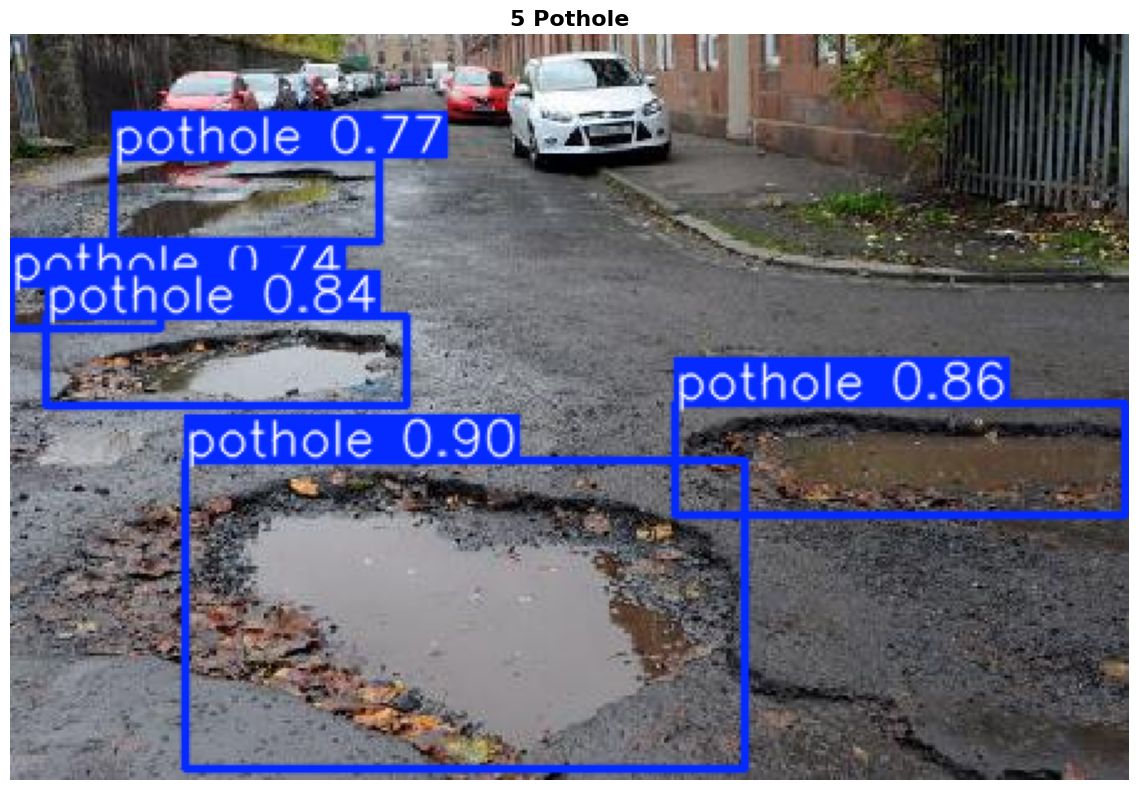

In [24]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

MODEL_PATH = "/content/runs/detect/pothole_yolov11l_optimized/weights/best.pt"
IMAGE_PATH = "/content/extracted_files/test images/images/0233f9defa6c4d20a482a267289131d1.jpg"

model = YOLO(MODEL_PATH)

results = model.predict(
    IMAGE_PATH,
    conf=0.12,
    iou=0.5,
    augment=True,
    verbose=False
)

detections = results[0].boxes
num_potholes = len(detections)

print(f"There are {num_potholes} pothole")

if num_potholes > 0:
    for i, box in enumerate(detections):
        conf = float(box.conf[0])
        xyxy = box.xyxy[0].cpu().numpy()
        print(f"Pothole {i+1}: Confidence = {conf:.3f}, Box = {xyxy}")

annotated_image = results[0].plot()
annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(annotated_image_rgb)
plt.axis('off')
plt.title(f"{num_potholes} Pothole", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
